# Explore confidence scores with Whisper

In [14]:
from utils import *
from confidence_utils import *

from datasets import load_dataset
from IPython.display import HTML as html_print
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
fleurs_en = load_dataset("google/fleurs", "en_us")
fleurs_en = fleurs_en.remove_columns(['id', 'num_samples', 'path', 'gender', 'lang_id', 'language', 'lang_group_id'])
fleurs_en = fleurs_en['train']#.select(range(100))

Found cached dataset fleurs (/home/antonin/.cache/huggingface/datasets/google___fleurs/en_us/2.0.0/aabb39fb29739c495517ac904e2886819b6e344702f0a5b5283cb178b087c94a)


  0%|          | 0/3 [00:00<?, ?it/s]

## 2. Load models

In [3]:
processor_en, model_en = load_whisper_with_confidence_scores('openai/whisper-base', 'English')

## 3. Run inference test

In [4]:
model_en.config.forced_decoder_ids = processor_en.get_decoder_prompt_ids(language = "en", task = "transcribe")
fleurs_en = fleurs_en.map(map_to_pred_and_confidence_scores, 
    fn_kwargs={"processor": processor_en, "model": model_en, "lang": "en"}, 
    batched=True, \
    remove_columns=['audio'], 
    batch_size = 1)
fleurs_en

  0%|          | 0/2602 [00:00<?, ?ba/s]

/home/antonin/Capstone-Audio-Transcription/whisper/confidence_utils.py:433: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Dataset({
    features: ['transcription', 'raw_transcription', 'string_pred', 'tokens_pred', 'probs_tokens_pred', 'ground_truth', 'wer'],
    num_rows: 2602
})

## 4. Save processed data with confidence indicators

In [5]:
fleurs_en.save_to_disk(os.path.join(predictions_confidence_path, 'fleurs_en'))

## 5. Load processed data with confidence indicators

In [6]:
fleurs_en = load_from_disk(os.path.join(predictions_confidence_path, 'fleurs_en'))
fleurs_en

Dataset({
    features: ['transcription', 'raw_transcription', 'string_pred', 'tokens_pred', 'probs_tokens_pred', 'ground_truth', 'wer'],
    num_rows: 2602
})

## 6. Display confidence colors

In [21]:
html_print(html_display_confidence(fleurs_en, range(10)))

## 7. Time to analyze

In [32]:
means_prob = []
medians_prob = []
inf_prob = []
wers = []

for row_index in range(fleurs_en.num_rows):
    means_prob.append(np.mean(fleurs_en[row_index]['probs_tokens_pred']))
    medians_prob.append(np.median(fleurs_en[row_index]['probs_tokens_pred']))
    inf_prob.append(np.min(fleurs_en[row_index]['probs_tokens_pred']))
    wers.append(100 * fleurs_en[row_index]['wer'])

In [25]:
np.argmax(wers)

2511

In [26]:
fleurs_en[2511]

{'transcription': 'if you booked your flights and accommodation for 2020 before the postponement was announced you may have a tricky situation',
 'raw_transcription': 'If you booked your flights and accommodation for 2020 before the postponement was announced, you may have a tricky situation.',
 'string_pred': 'you',
 'tokens_pred': ['Ġyou'],
 'probs_tokens_pred': [0.14399981498718262],
 'ground_truth': 'if you booked your flights and accommodation for 2020 before the postponement was announced you may have a tricky situation',
 'wer': 19.0}

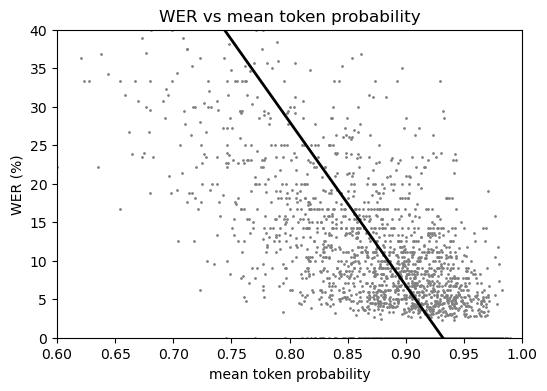

In [58]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(means_prob, wers, s = 1, color='grey')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(means_prob, wers, 1)

x = np.linspace(0.6,1,100)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b, linewidth=2.0, color='black')

# plot
plt.xlabel('mean token probability')
plt.ylabel('WER (%)')
plt.xlim(0.6,1)
plt.ylim(0,40)
plt.title('WER vs mean token probability')
plt.show()

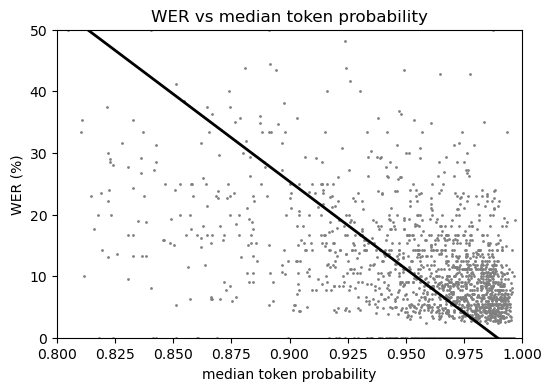

In [59]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(medians_prob, wers, s = 1, color='grey')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(medians_prob, wers, 1)

x = np.linspace(0.8,1,100)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b, linewidth=2.0, color='black')
# plot
plt.xlabel('median token probability')
plt.ylabel('WER (%)')
plt.xlim(0.8,1)
plt.ylim(0,50)
plt.title('WER vs median token probability')
plt.show()

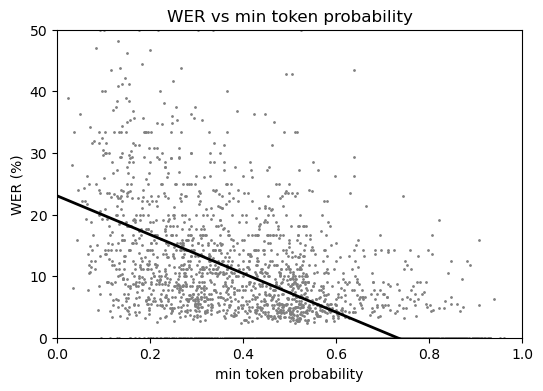

In [61]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(inf_prob, wers, s = 1, color='grey')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(inf_prob, wers, 1)

x = np.linspace(0,1,100)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b, linewidth=2.0, color='black')

# plot
plt.xlabel('min token probability')
plt.ylabel('WER (%)')
plt.xlim(0,1)
plt.ylim(0,50)
plt.title('WER vs min token probability')
plt.show()